In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer  
nltk.download('stopwords') 
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nguyenlong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
df = pd.read_csv("fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## Kiểm tra dữ liệu


In [66]:
df.describe()


,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

## Chúng ta sẽ xử lý dữ liệu theo 2 hướng 
### Nhữnh dữ liệu có > 80% missing value ta sẽ loại bỏ luôn
### Những dữ liệu có < 80% missing value ta sẽ fill bằng những dữ liệu hợp lý

In [68]:
missing_percent = df.isnull().mean() * 100
print(missing_percent)

job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.078300
benefits               40.335570
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
dtype: float64


In [69]:

df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Sau khi đã loại bỏ cột có missing value lớn thì ta sẽ bắt đầu fill những dữ liệu bị thiếu

In [70]:
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].fillna('')
categorical_columns = ['location', 'department','employment_type', 'required_experience', 'required_education', 'industry', 'function']
df[categorical_columns] = df[categorical_columns].fillna('Unknown')
df.isnull().sum()

job_id                     0
title                      0
location                   0
department                 0
salary_range           15012
company_profile            0
description                0
requirements               0
benefits                   0
telecommuting              0
has_company_logo           0
has_questions              0
employment_type            0
required_experience        0
required_education         0
industry                   0
function                   0
fraudulent                 0
dtype: int64

/var/folders/q2/rf1fqv4x35d9zrv8kmtb11ph0000gn/T/ipykernel_71634/47552614.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["Real Post (17014) [0's]", "Fake Post (866) [1's]"])


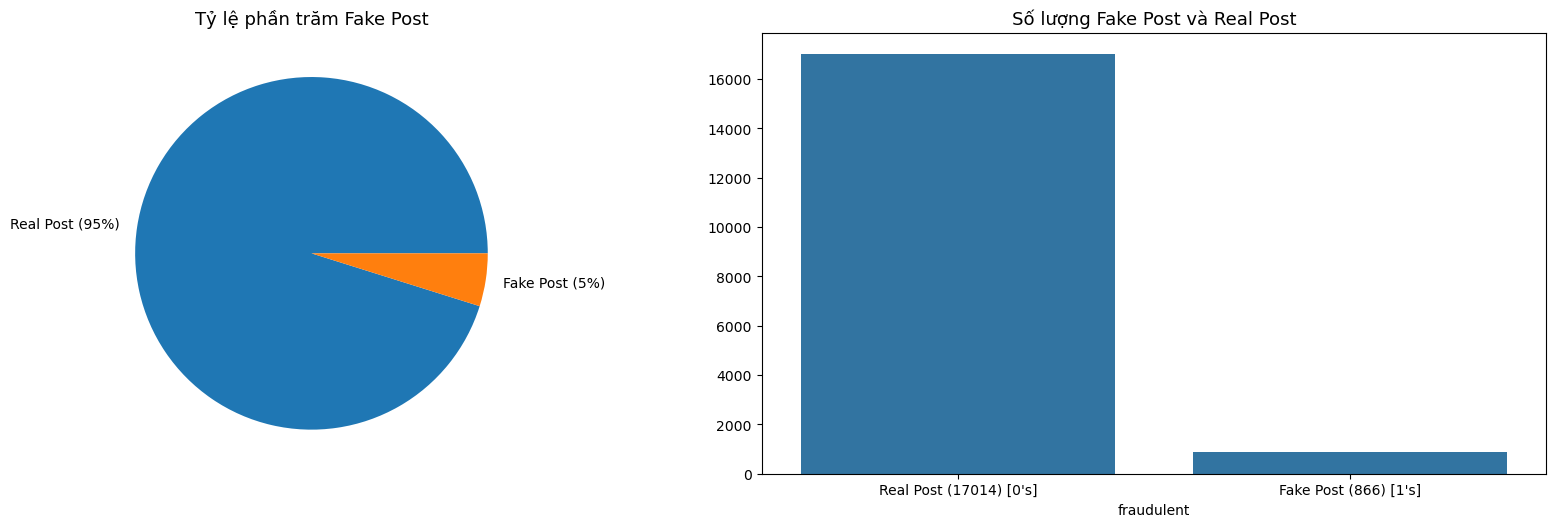

In [71]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
plt.tight_layout()

df["fraudulent"].value_counts().plot(kind='pie', ax=axes[0], labels=['Real Post (95%)', 'Fake Post (5%)'])
temp = df["fraudulent"].value_counts()
sns.barplot(x=temp.index,y=temp, ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post (17014) [0's]", "Fake Post (866) [1's]"])

axes[0].set_title('Tỷ lệ phần trăm Fake Post', fontsize=13)
axes[1].set_title('Số lượng Fake Post và Real Post', fontsize=13)

plt.show()

### Sau khi kiểm tra Fake Post và Real Post ta sẽ bắt đầu vector hoá bằng cách kết hợp các cột text

In [72]:
df['text_combined'] = df['title'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']

In [73]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()  # Chuyển về lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Loại bỏ ký tự đặc biệt, số, URL, email
    text = re.sub(r'\s+', ' ', text).strip()  # Loại bỏ khoảng trắng thừa
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]  # Stemming và loại stop words
    return ' '.join(words)

In [74]:
df_encoded = pd.get_dummies(df[categorical_columns], drop_first=True)  # Tránh dummy variable trap
df = pd.concat([df, df_encoded], axis=1)
df = df.drop(categorical_columns, axis=1)

In [75]:
tfidf = TfidfVectorizer(max_features=5000)  # Giới hạn 5000 từ phổ biến nhất để tránh overlit
X_text = tfidf.fit_transform(df['text_combined'])

In [76]:
other_features = df[['telecommuting', 'has_company_logo', 'has_questions']]  # Các cột nhị phân
X = hstack([X_text, other_features.values])  # Kết hợp text vector với các đặc trưng khác
y = df['fraudulent']

In [77]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(pd.Series(y_resampled).value_counts())
df.head()

fraudulent
0    17014
1    17014
Name: count, dtype: int64


,job_id,title,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,...,function_Purchasing,function_Quality Assurance,function_Research,function_Sales,function_Science,function_Strategy/Planning,function_Supply Chain,function_Training,function_Unknown,function_Writing/Editing
0,1,Marketing Intern,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,...,False,False,False,False,False,False,False,False,False,False
1,2,Customer Service - Cloud Video Production,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,...,False,False,False,False,False,False,False,False,False,False
2,3,Commissioning Machinery Assistant (CMA),NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,...,False,False,False,False,False,False,False,False,True,False
3,4,Account Executive - Washington DC,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,...,False,False,False,True,False,False,False,False,False,False
4,5,Bill Review Manager,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,...,False,False,False,False,False,False,False,False,False,False


## Sau khi đã xử lý cân bằng và cleaning data ta sẽ bắt đầu chia tập train/test

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
np.save('X_train.npy', X_train.toarray())  # Chuyển sparse matrix thành array nếu cần
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test.toarray())
np.save('y_test.npy', y_test)